In [1]:
from FinancialMachineLearning.features.microstructure import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import os
os.chdir('..')
os.chdir('..')
os.getcwd()

'/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning'

In [3]:
data = pd.read_csv('clean_data.csv', index_col = 0)

In [4]:
data

,price,bid,ask,size,v,dv
dates,,,,,,
2009-09-28 09:30:00,50.79,50.70,50.79,100,100,5079.00
2009-09-28 09:30:00,50.71,50.70,50.79,638,638,32352.98
2009-09-28 09:31:32,50.75,50.75,50.76,100,100,5075.00
2009-09-28 09:31:33,50.75,50.72,50.75,100,100,5075.00
2009-09-28 09:31:50,50.75,50.73,50.76,300,300,15225.00
...,...,...,...,...,...,...
2018-10-05 15:59:59,116.20,116.18,116.19,2000,2000,232400.00
2018-10-05 15:59:59,116.20,116.18,116.19,3900,3900,453180.00
2018-10-05 16:00:00,116.22,116.20,116.21,42884,42884,4983978.48


#### Tick rule

In [5]:
aggressor = TickRule(data['price'])
aggressor

dates
2009-09-28 09:30:00    1.0
2009-09-28 09:30:00   -1.0
2009-09-28 09:31:32    1.0
2009-09-28 09:31:33    1.0
2009-09-28 09:31:50    1.0
                      ... 
2018-10-05 15:59:59    1.0
2018-10-05 15:59:59    1.0
2018-10-05 16:00:00    1.0
2018-10-05 16:10:00    1.0
2018-10-05 18:30:00    1.0
Length: 1416200, dtype: float64

#### The Roll Model

In [6]:
spread, noise = RollModel(data['price'])
spread, noise

(0.29004042406268343, -0.16645774734381807)

#### Range Volatility

In [7]:
from FinancialMachineLearning.barsampling.standard_bar import dollarBar

date_time = pd.Series(data.index)
data.index = range(len(data))
new_data = pd.concat([date_time, data['price'], data['v']], axis=1)
new_data.columns = ['date', 'price', 'volume']
print(new_data.head(20))
print('Rows:', new_data.shape[0])
new_data.to_csv('./Data/maks_tick_data.csv', index=False)

                   date    price  volume
0   2009-09-28 09:30:00  50.7900     100
1   2009-09-28 09:30:00  50.7100     638
2   2009-09-28 09:31:32  50.7500     100
3   2009-09-28 09:31:33  50.7500     100
4   2009-09-28 09:31:50  50.7500     300
5   2009-09-28 09:31:51  50.7500     300
6   2009-09-28 09:32:06  50.7800     300
7   2009-09-28 09:32:06  50.7800     500
8   2009-09-28 09:32:06  50.7800     100
9   2009-09-28 09:32:56  50.8226     100
10  2009-09-28 09:33:02  50.8100     500
11  2009-09-28 09:33:02  50.8100     300
12  2009-09-28 09:33:08  50.8200     500
13  2009-09-28 09:33:08  50.8200     298
14  2009-09-28 09:33:35  50.8100     100
15  2009-09-28 09:33:54  50.8200     100
16  2009-09-28 09:33:54  50.8200     400
17  2009-09-28 09:34:58  50.8000     100
18  2009-09-28 09:34:58  50.8000     200
19  2009-09-28 09:36:32  50.8500     300
Rows: 1416200


In [8]:
threshold = 1000000
dv = dollarBar('./Data/maks_tick_data.csv', threshold = threshold, batch_size = 1000000, verbose = True)
dv

Reading data in batches:
Batch number: 0
Batch number: 1
Returning bars 


,date_time,open,high,low,close,volume
0,2009-09-28 09:46:35,50.7900,51.0700,50.710,51.07,19844
1,2009-09-28 09:53:49,51.0700,51.1500,51.050,51.14,20324
2,2009-09-28 09:55:26,51.1400,51.1500,51.129,51.14,19622
3,2009-09-28 10:02:52,51.1400,51.2600,51.080,51.25,22319
4,2009-09-28 10:10:21,51.2500,51.2900,51.190,51.29,21519
...,...,...,...,...,...,...
50761,2018-10-05 15:58:23,116.2425,116.2425,116.160,116.19,9647
50762,2018-10-05 15:59:20,116.2000,116.2125,116.150,116.18,8821
50763,2018-10-05 15:59:55,116.1800,116.2100,116.140,116.19,9196
50764,2018-10-05 15:59:59,116.2000,116.2000,116.190,116.20,9700


In [9]:
vol = RangeVolatility(dv.high, dv.low, window = 50)

Text(0.5, 1.0, 'Estimated Range Volatility')

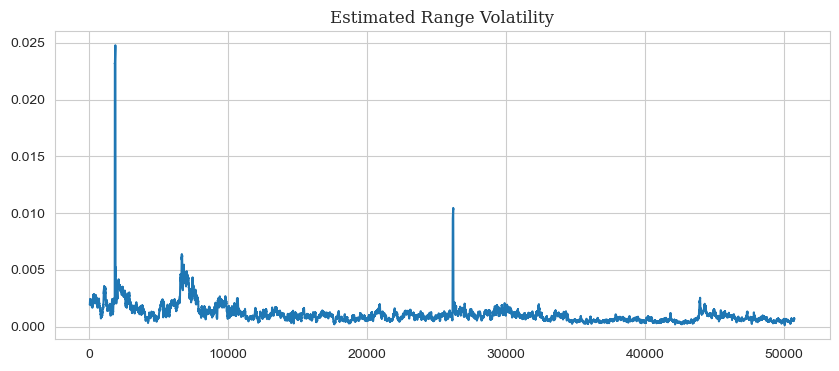

In [10]:
plt.figure(figsize = (10,4))
vol.plot()
plt.title('Estimated Range Volatility', fontsize = 12, fontfamily = 'Serif')

Text(0.5, 1.0, 'Dollar Value Bars')

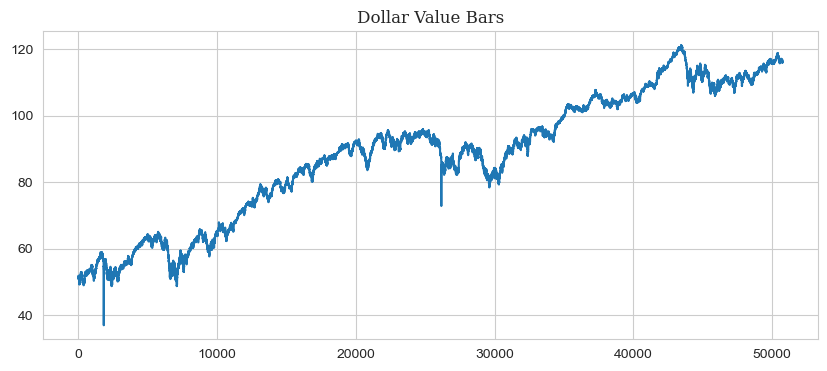

In [11]:
plt.figure(figsize = (10,4))
dv.close.plot()
plt.title('Dollar Value Bars', fontsize = 12, fontfamily = 'Serif')

#### Corwin Schultz Spread

In [12]:
spread = CorwinSchultzSpread(dv.high, dv.low, 100)
vol = BeckerParkinsonVolatility(dv.high, dv.low, 100)

Text(0.5, 1.0, 'Corwin Schultz Spread')

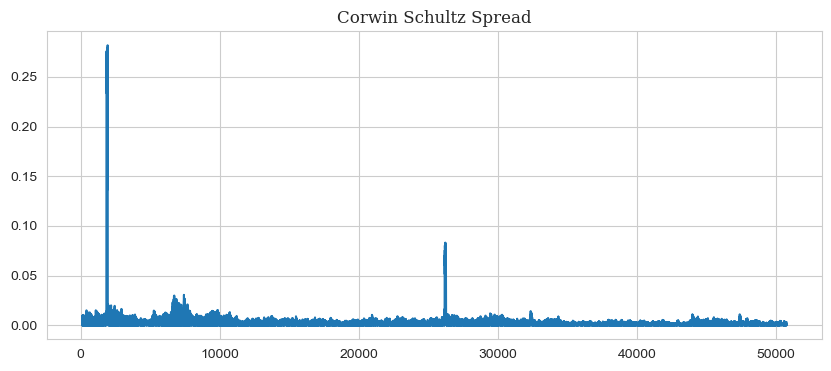

In [13]:
plt.figure(figsize = (10,4))
plt.plot(spread)
plt.title('Corwin Schultz Spread', fontsize = 12, fontfamily = 'Serif')

Text(0.5, 1.0, 'Estimated Backer Parkinson Volatility')

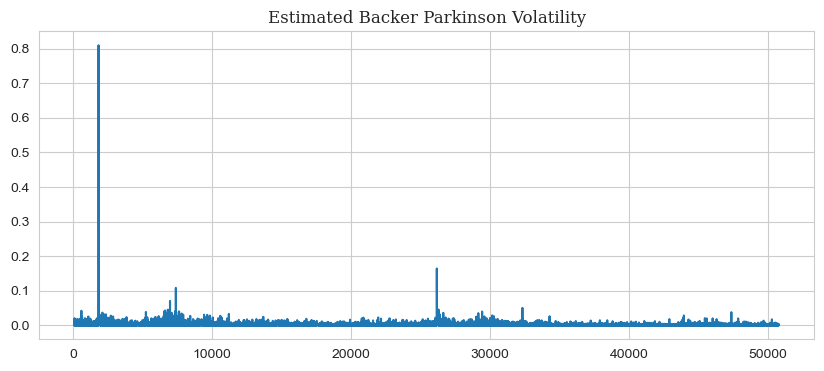

In [14]:
plt.figure(figsize = (10,4))
plt.plot(vol)
plt.title('Estimated Backer Parkinson Volatility', fontsize = 12, fontfamily = 'Serif')

#### Kyle's Lambda

In [15]:
aggressor = TickRule(dv['close'])
aggressor

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
50761   -1.0
50762   -1.0
50763    1.0
50764    1.0
50765    1.0
Length: 50766, dtype: float64

In [16]:
#from FinancialMachineLearning.barsampling.bar_feature import BarFeature
#kyles_lambda_feature = BarFeature(name = 'kyles_lambda', function= lambda df: kyleLambda(dv['close'], dv['volume'], aggressor))
#bars = dollarBar('./Data/maks_tick_data.csv', threshold = 1000000, batch_size = 1000000,additional_features=[kyles_lambda_feature])
#plt.figure(figsize = (10,4))
#bars['kyles_lambda'].hist(bins = 5)
#plt.title(r"Kyle's $\lambda$", fontsize = 12, fontfamily = 'Serif')

In [17]:
lambda_feature = Lambda(dv['close'], dv['volume'])
kyle_lambda = lambda_feature.kyle(signs = aggressor)
kyle_lambda

0                 NaN
1        3.444204e-06
2        0.000000e+00
3        4.928536e-06
4        1.858822e-06
             ...     
50761    5.182958e-06
50762    1.133658e-06
50763    1.087429e-06
50764    1.030928e-06
50765    4.274966e-07
Length: 50766, dtype: float64

Text(0.5, 1.0, "Kyle's $\\lambda$")

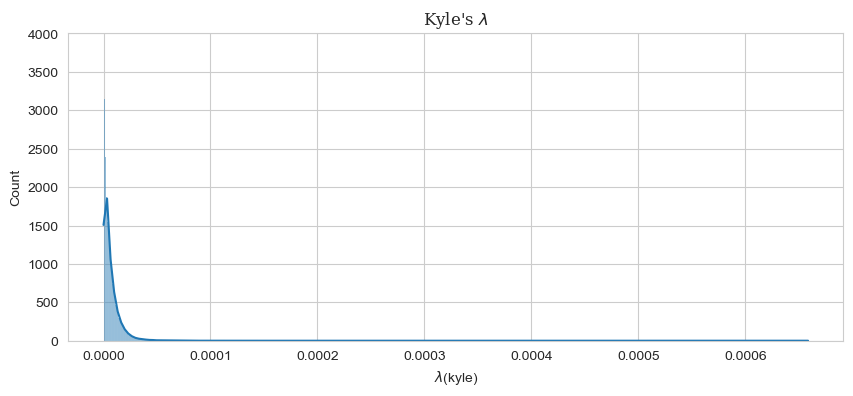

In [18]:
import seaborn as sns
fig , ax = plt.subplots(figsize = (10, 4))
sns.histplot(kyle_lambda, kde = True, ax = ax)
plt.xlabel(r"$\lambda$(kyle)")
plt.title(r"Kyle's $\lambda$", fontsize = 12, fontfamily = 'Serif')

#### Amihud's Lambda

In [19]:
#dollar_volume_feature = BarFeature(name = 'dollar_volume', function= lambda df: dollarVolume(dv['close'], dv['volume']))
#bars2 = dollarBar('./Data/maks_tick_data.csv', threshold = 1000000, batch_size = 1000000,additional_features = [dollar_volume_feature])
#bars2['dollar_volume']
#lambda_ = amihudLambda(bars['close'], bars['dollar_volume'])
#lambda_

In [20]:
amihud_lambda = lambda_feature.aminud()
amihud_lambda

0                 NaN
1        6.739467e-08
2        0.000000e+00
3        9.626991e-08
4        3.625556e-08
             ...     
50761    4.459802e-08
50762    9.757355e-09
50763    9.359464e-09
50764    8.872394e-09
50765    3.678656e-09
Length: 50766, dtype: float64

Text(0.5, 1.0, "Amihud's $\\lambda$")

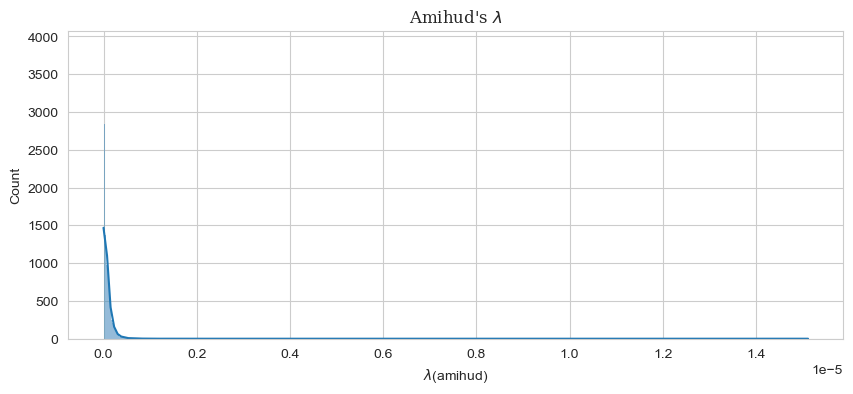

In [21]:
fig , ax = plt.subplots(figsize = (10, 4))
sns.histplot(amihud_lambda, kde = True, ax = ax)
plt.xlabel(r"$\lambda$(amihud)")
plt.title(r"Amihud's $\lambda$", fontsize = 12, fontfamily = 'Serif')

#### Hasbrouck's Lambda

In [22]:
#def get_hasbroucks_flow(df):
    #tick_signs = TickRule(df['price'])
    #return hasbroucks_flow(df['price'], df['volume'], tick_signs)
#hasbroucks_flow_feature = BarFeature(name = 'hasbroucks_flow', function=get_hasbroucks_flow)
#bars = dollarBar('./Data/maks_tick_data.csv', threshold = 1000000, batch_size = 1000000,additional_features=[hasbroucks_flow_feature])
#lambda_ = hasbrouckLambda(bars['close'], bars['hasbroucks_flow'], aggressor)
#lambda_

In [23]:
hasbrouck_lambda = lambda_feature.hasbrouck(signs = aggressor)
hasbrouck_lambda

0                 NaN
1        9.607936e-06
2        0.000000e+00
3        1.438229e-05
4        5.318457e-06
             ...     
50761    4.380379e-06
50762    9.164125e-07
50763    8.975331e-07
50764    8.738295e-07
50765    7.956789e-07
Length: 50766, dtype: float64

Text(0.5, 1.0, "Hasbrouck's $\\lambda$")

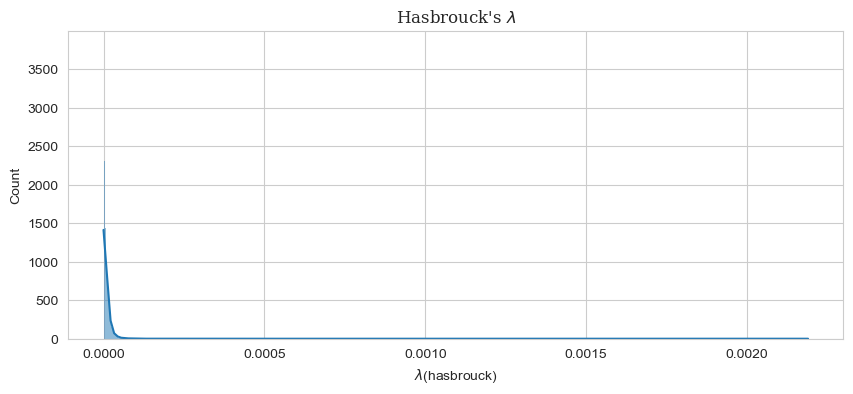

In [24]:
fig , ax = plt.subplots(figsize = (10, 4))
sns.histplot(hasbrouck_lambda, kde = True, ax = ax)
plt.xlabel(r"$\lambda$(hasbrouck)")
plt.title(r"Hasbrouck's $\lambda$", fontsize = 12, fontfamily = 'Serif')

#### Third Generation : Sequential Trade Models

**VPIN**

In [25]:
from FinancialMachineLearning.barsampling.standard_bar import volumeBar

def buy_volume(df):
    tick_signs = TickRule(df['price'])
    return (df['volume'] * (tick_signs > 0)).sum()
def sell_volume(df):
    tick_signs = TickRule(df['price'])
    return (df['volume'] * (tick_signs < 0)).sum()

In [27]:
from FinancialMachineLearning.barsampling.bar_feature import BarFeature
buy_volume_feature = BarFeature(name = 'buy_volume', function = buy_volume)
sell_volume_feature = BarFeature(name = 'sell_volume', function = sell_volume)

In [28]:
bars = volumeBar('./Data/maks_tick_data.csv', 
                 additional_features = [buy_volume_feature, sell_volume_feature])
vol_thres = 10000
vpin_series = vpin(bars['buy_volume'], bars['sell_volume'], vol_thres, 5)

Reading data in batches:
Batch number: 0
Returning bars 


Text(0.5, 1.0, 'VPIN model & Dollar Value Bar')

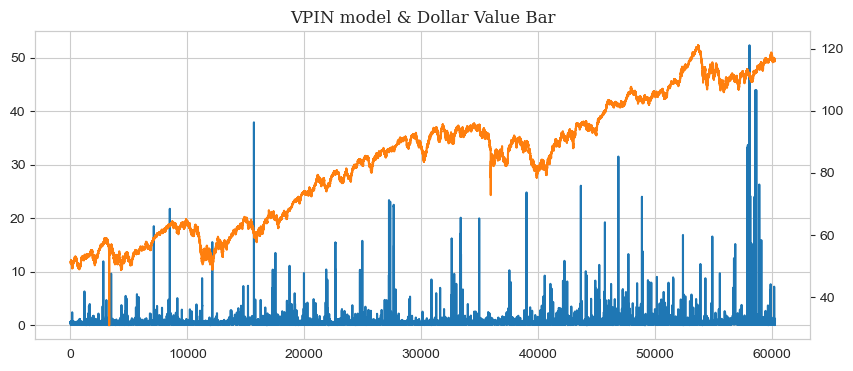

In [29]:
plt.figure(figsize=(10, 4))
vpin_series.plot()
bars['close'].plot(secondary_y = True)
plt.title('VPIN model & Dollar Value Bar', fontsize = 12, fontfamily = 'Serif')

Text(0.5, 1.0, 'VPIN model & Dollar Value Bar')

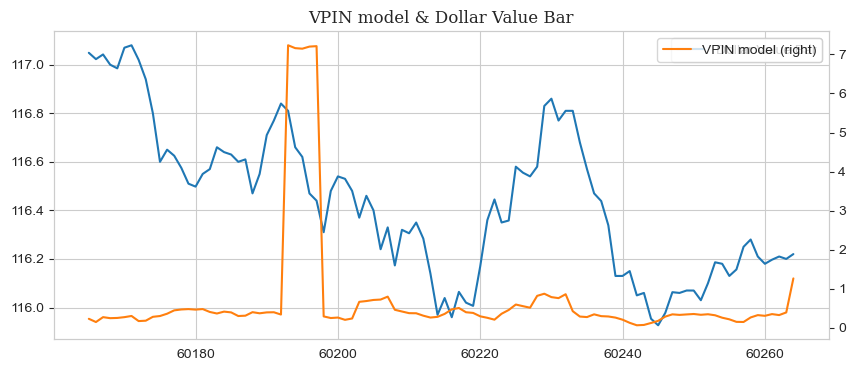

In [32]:
plt.figure(figsize=(10, 4))
bars['close'][-100:].plot(label = 'Dollar Value Bar')
plt.legend()
vpin_series[-100:].plot(label = 'VPIN model', secondary_y = True)
plt.legend()
plt.title('VPIN model & Dollar Value Bar', fontsize = 12, fontfamily = 'Serif')